In [1]:
import moth
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy
import scipy.signal
import scipy.optimize as optim
import h5py

sns.set_theme(context='poster')

PATH = '/storage/home/adz6/group/project'
DIGDATAPATH = os.path.join(PATH, 'datasets', 'data', 'lab', 'dig')
VNADATAPATH = os.path.join(PATH, 'datasets', 'data', 'lab', 'vna')
#DAQDATAPATH = os.path.join(PATH, 'daq_data')
#MOTHPATH = os.path.join(PATH, 'moth')
#MOTHDATA = os.path.join(MOTHPATH, 'data/datasets')
#PLOTPATH = os.path.join(PATH, 'plots/moth')
#MOTHRESULTS = os.path.join(PATH, 'results/moth')

def IdealCyclotronPhaseModel(rotation_angle, radial_pos, wavelengths):
    
    slope = -1 
    
    linear_component = rotation_angle.reshape(rotation_angle.size, 1) * slope
    
    amplitudes = 2 * np.pi * radial_pos / wavelengths
    
    sinusoidal_component = amplitudes.reshape(1, amplitudes.size) * np.sin(rotation_angle + np.pi).reshape(rotation_angle.size, 1)
    
    return linear_component + sinusoidal_component

def IdealCyclotronAmplitudeModel(rotation_angle, radial_pos, mean_power_onaxis, array_radius = 0.1):
    
    initial_phase = np.pi
    x_antenna = radial_pos * np.cos(initial_phase)
    y_antenna = radial_pos * np.sin(initial_phase)
    
    x_array = array_radius * np.cos(rotation_angle)
    y_array = array_radius * np.sin(rotation_angle)
    
    distance = np.sqrt((x_antenna - x_array) ** 2 + (y_antenna - y_array) ** 2)
    
    distance_rel_to_array = distance / array_radius
    
    return mean_power_onaxis.reshape(1, mean_power_onaxis.size) / distance_rel_to_array.reshape(rotation_angle.size, 1)
    

def FitCyclotronModel(rotation_angle, a, b):
    
    return a * rotation_angle + b * np.sin(rotation_angle)


def CalculateCorrection_old(vna_trace_path, name, nch=120):
    
    file = h5py.File(vna_trace_path, 'r')
    
    correction_file = h5py.File(name, 'w')
    
    #print(file.keys())
    
    for i, key in enumerate(file.keys()):
        
        correction_file.create_group(key)
        # data has 121 for antenna/rotation dimension, should have 120
        correction_file[key].create_dataset('phase', (file[key]['array'].shape[0], nch, file[key]['array'].shape[2]))
        correction_file[key].create_dataset('amplitude', (file[key]['array'].shape[0], nch, file[key]['array'].shape[2]))
        correction_file[key].create_dataset('freq', data = file[key]['freq'][:])
        
        mean_onaxis_amplitudes = np.mean(abs(file[key]['array'][0, 0:nch, :]), axis=0)
        for iradius in range(file[key]['array'].shape[0]):
            
            # data has 121 for antenna/rotation dimension, should have 120
            trace_array = file[key]['array'][iradius, 0:nch, :]
            
            rotation_angles = 2 * np.pi * np.arange(0, trace_array.shape[0], 1) / trace_array.shape[0]
            
            amplitudes = abs(trace_array)
            
            phases = np.unwrap(np.angle(trace_array), axis=0)
            
            phases = phases - phases[0, :].reshape((1, phases.shape[-1]))
            
            c = 2.998e8
            frequencies = file[key]['freq'][:]
            wavelengths = c / frequencies
            
            radial_position = iradius * 0.001
            
            # phases + correction = cyclotron_model
            phase_correction = IdealCyclotronPhaseModel(rotation_angles, radial_position, wavelengths) - phases

            correction_file[key]['phase'][iradius, :, :] = phase_correction
            
            # amplitudes * correction = cyclotron_model
            amp_correction = IdealCyclotronAmplitudeModel(rotation_angles, radial_position, mean_onaxis_amplitudes) / amplitudes

            correction_file[key]['amplitude'][iradius, :, :] = amp_correction
            
            
    correction_file.close()
        
# use only the on-axis measurements averaged over all axial measurements as a correction
#
def CalculateCorrection(vna_trace_path, name, nch=120):
    
    file = h5py.File(vna_trace_path, 'r')
    
    correction_file = h5py.File(name, 'w')
    
    correction_file.create_dataset('phase', (nch, file[list(file.keys())[0]]['array'].shape[2]))
    correction_file.create_dataset('amplitude', (nch, file[list(file.keys())[0]]['array'].shape[2]))
    correction_file.create_dataset('freq', data = file[list(file.keys())[0]]['freq'][:])
    
    #print(file.keys())
    data_list = []
    frequencies = file[list(file.keys())[0]]['freq'][:]
    for i, key in enumerate(file.keys()):
        
        #correction_file.create_group(key)
        # data has 121 for antenna/rotation dimension, should have 120
        
        #mean_onaxis_amplitudes = np.mean(abs(file[key]['array'][0, 0:nch, :]), axis=-1)

        
        #plt.figure(figsize=(13, 8))
        #plt.plot(np.arange(0, 360, 3), np.mean(abs(file[key]['array'][0, 0:nch, :]), axis=-1))
        #plt.xlabel('Angle')
        #plt.ylabel('')
        #plt.show
         
        # data has 121 for antenna/rotation dimension, should have 120
        data_list.append(file[key]['array'][0, 0:nch, :])
        
    data_array = np.array(data_list)
    print(data_array.shape)
    axial_average_amplitude = np.mean(abs(data_array), axis=0)
    axial_average_phase = np.mean(np.unwrap(np.angle(data_array), axis=1), axis=0)
    print(axial_average_phase.shape)
    axial_average_phase -= axial_average_phase[0, :]
    
    axial_average_phase_derivative = np.gradient(axial_average_phase, axis=0)
    
    
    
    plt.figure(figsize=(13, 8))
    for ifreq in np.arange(0, 801, 200):
        
        
        plt.plot(np.arange(0, 360, 3), axial_average_amplitude[:, ifreq], label=f'Freq. = {round(frequencies[ifreq]* 1e-9, 3)} GHz')
        
        plt.xlabel('Angle')
        plt.ylabel('Axial Average Magnitude')
    
    plt.legend(loc=4)
    plt.show()
    
    
    
    plt.figure(figsize=(13, 8))
    for ifreq in np.arange(0, 801, 200):
        
        
        plt.plot(np.arange(0, 360, 3), axial_average_phase[:, ifreq], label=f'Freq. = {round(frequencies[ifreq]* 1e-9, 3)} GHz')
        
        plt.xlabel('Angle')
        plt.ylabel('Axial Average Phase')
    
    #plt.legend(loc=8)
    plt.show()
    
    
    plt.figure(figsize=(13, 8))
    for ifreq in np.arange(0, 801, 200):
        
        
        plt.plot(np.arange(0, 360, 3), axial_average_phase_derivative[:, ifreq], label=f'Freq. = {round(frequencies[ifreq]* 1e-9, 3)} GHz')
        
        plt.xlabel('Angle')
        plt.ylabel('Axial Average Phase Derivative')
    
    plt.legend(loc=1)
    plt.show()
    
        
    '''  
        rotation_angles = 2 * np.pi * np.arange(0, trace_array.shape[0], 1) / trace_array.shape[0]

        amplitudes = abs(trace_array)

        phases = np.unwrap(np.angle(trace_array), axis=0)

        phases = phases - phases[0, :].reshape((1, phases.shape[-1]))

        c = 2.998e8
        frequencies = file[key]['freq'][:]
        wavelengths = c / frequencies

        # phases + correction = cyclotron_model
        phase_correction = IdealCyclotronPhaseModel(rotation_angles, 0.00, wavelengths) - phases

        correction_file['phase'][:, :] += phase_correction

        # amplitudes * correction = cyclotron_model
        amp_correction = IdealCyclotronAmplitudeModel(rotation_angles, 0.00, mean_onaxis_amplitudes) / amplitudes

        correction_file['amplitude'][:, :] += amp_correction
        
        
    correction_file['phase'][:, :] /= len(list(file.keys()))
    correction_file['amplitude'][:, :] /= len(list(file.keys()))
    '''
    correction_file.close()


In [2]:
os.listdir(DIGDATAPATH)

['211213_cres2_meas_3ch_debug.h5',
 '211202_cres2_3ch_horn_offaxis_sweep.h5',
 '211213_cres2_meas_3ch.h5',
 '211213_cres2_meas_3ch_10slot.h5']

In [3]:
os.listdir(VNADATAPATH)

['211206_cres2_vna_trace.h5',
 '211214_cres2_vna_trace_10slot.h5',
 '211220_cres2_vna_trace.h5',
 '211214_cres2_vna_trace.h5']

In [4]:
filepath = os.path.join(VNADATAPATH, '211220_cres2_vna_trace.h5')

In [5]:
name = '220119_cres2_vna_correction.h5'

save_path = os.path.join(PATH, 'results', 'moth', 'vna_correction_files', name)

(5, 120, 801)
(120, 801)


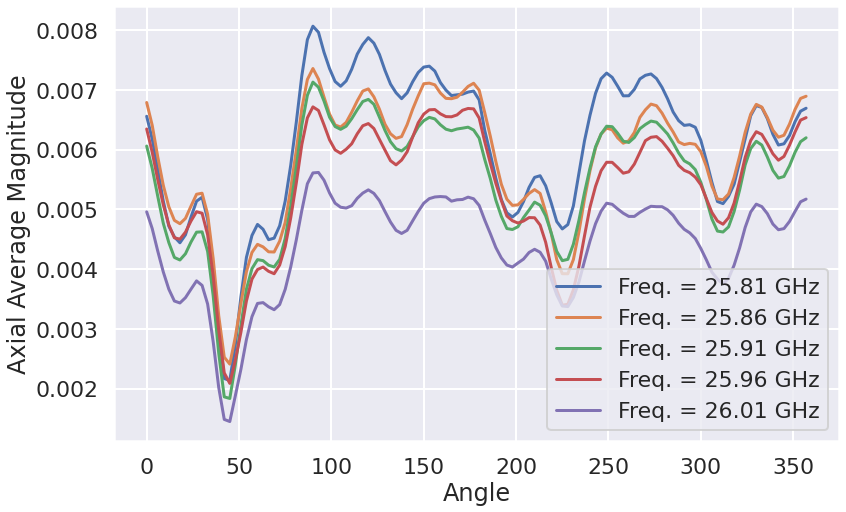

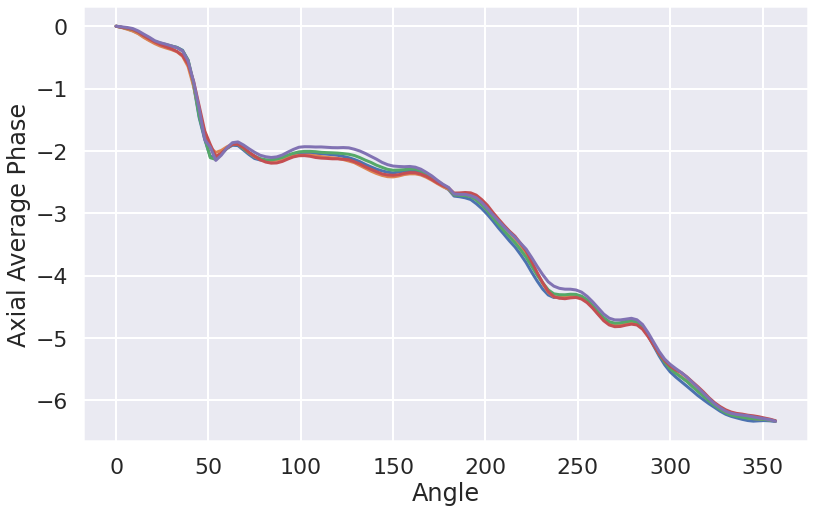

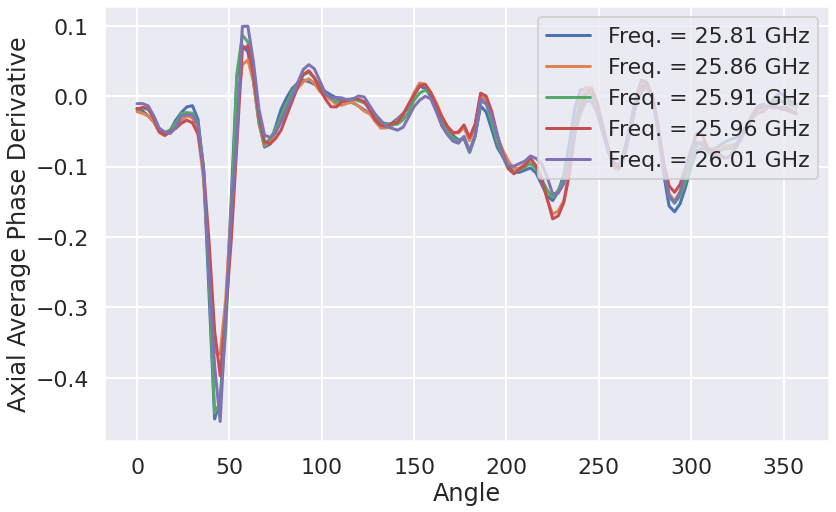

In [6]:
CalculateCorrection(filepath, save_path)

# plot correction

In [7]:
name = '220119_cres2_vna_correction.h5'

correction = h5py.File(os.path.join(os.path.join(PATH, 'results', 'moth', 'vna_correction_files', name)), 'r')


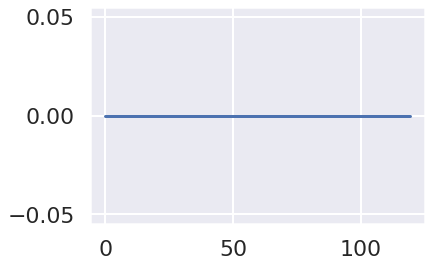

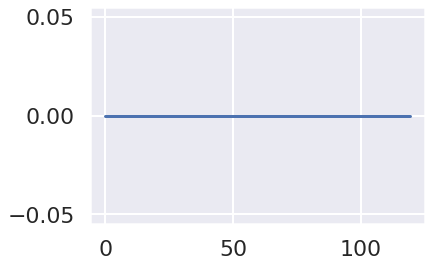

In [8]:
ifreq = 0
plt.figure()
plt.plot(correction['amplitude'][:, ifreq])

plt.figure()
plt.plot(correction['phase'][:, ifreq])